Uses training and import code from GDL lab 1

In [ ]:
!pip uninstall torch -y

Found existing installation: torch 2.0.0+cu118
Uninstalling torch-2.0.0+cu118:
  Successfully uninstalled torch-2.0.0+cu118


In [ ]:
!pip install torch==1.13.1 torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.13.1+cu116.html
!pip install networkx
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.13.1+cu116.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.4/887.4 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 62.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 52.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 66.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.4/868.4 KB 60.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 616.2/616.2 KB 53.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 KB 65.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 M

In [ ]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch_geometric
import torch_geometric.nn.aggr as aggr
from torch_geometric.datasets import Planetoid, ZINC, GNNBenchmarkDataset
from torch_scatter import scatter_mean, scatter_max, scatter_sum, scatter_add
from torch_geometric.utils import to_dense_adj, to_undirected, remove_self_loops, sort_edge_index
from torch.nn import Parameter

import pdb

import matplotlib.pyplot as plt

import matplotlib.cm as cm

from typing import Mapping, Tuple, Sequence, List

import scipy.linalg
from scipy.linalg import block_diag

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
print(device)

cuda


Prepare the CORA dataset

In [ ]:
dataset = torch_geometric.datasets.Planetoid(root='/', name='Cora')
IN_SIZE = dataset.num_features
OUT_SIZE = dataset.num_classes

Processing...
Done!


In [ ]:
data = dataset[0]
data.x = data.x.to(device)
data.y = data.y.to(device)

data.edge_index = data.edge_index.to(device)

In [ ]:
data.edge_index.shape, data.x.shape, data.edge_index

(torch.Size([2, 10556]),
 torch.Size([2708, 1433]),
 tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
         [ 633, 1862, 2582,  ...,  598, 1473, 2706]], device='cuda:0'))

In [ ]:
# @title Hyperparameters

NUM_EPOCHS =  100 #@param {type:"integer"}
LR         = 0.005 #@param {type:"number"}
NUM_LAYERS =  2 #@param {type:"integer"}
HIDDEN_SIZE =  32 #@param {type:"integer"}

Set up the aggregation classes

In [ ]:
# First up, the Deep Set sum decomposition

class XavierLinear(nn.Module):
    def __init__(self, sz_in, sz_out):
        # Creates a new linear layer with xavier initialisation for ultimate spice
        super().__init__()
        self.W = nn.Parameter(torch.empty(size=(sz_in, sz_out)))
        nn.init.xavier_normal_(self.W)
        self.b = nn.Parameter(torch.empty(size=(1, sz_out)))
        nn.init.xavier_normal_(self.b)

    def forward(self,X):
        return (X @ self.W) + self.b

def get_new_deepset(dim):
    phi = nn.Sequential(
        XavierLinear(dim,dim),
        nn.LeakyReLU(),
        XavierLinear(dim,dim),
        nn.LeakyReLU()
    )

    rho = nn.Sequential(
        XavierLinear(dim,dim),
        nn.LeakyReLU(),
        XavierLinear(dim,dim),
        nn.LeakyReLU()
    )

    return aggr.DeepSetsAggregation(phi, rho)

def get_new_SAB(dim):
    return aggr.SetTransformerAggregation(dim, num_encoder_blocks=2, num_decoder_blocks=2)

def get_aggr(aggr_string, dim):
    # Given the name of the aggregation scheme, return something the model can use
    if aggr_string == "deep set":
        return get_new_deepset(dim)
    elif aggr_string == "set trans.":
        return get_new_SAB(dim)
    elif aggr_string == "gmt":
        return aggr.GraphMultisetTransformer(dim, 1)
    else: # The rest of them are readable from the string alias
        return aggr_string

Set up the models - much as I would have loved to use the default model implementations, unfortunately the aggregators need to take in the layer sizes which doesn't seem to be implemented yet.

Training and testing

In [ ]:
# Train the given model on the given graph for num_epochs
def train(model, silent=False):
    model = model.to(device)
    adj = data.edge_index

    # Set up the loss and the optimizer
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LR)

    # A utility function to compute the accuracy
    def get_acc(outs, y, mask):
        return ((outs[mask].argmax(dim=1) == y[mask]).sum().float() / mask.sum()).item()

    test_accs = [get_acc(model(data.x, adj), data.y, data.test_mask)]
    for epoch in range(NUM_EPOCHS):
        # Zero grads -> forward pass -> compute loss -> backprop
        optimizer.zero_grad()
        outs = model(data.x, adj)
        loss = loss_fn(outs[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        # Compute accuracies, print only if this is the best result so far
        acc_val = get_acc(outs, data.y, data.val_mask)
        acc_test = get_acc(outs, data.y, data.test_mask)
        test_accs.append(acc_test)
        if (epoch+1)%10==0 and not silent:
            print(f'[Epoch {epoch+1}/{NUM_EPOCHS}] Loss: {loss} | Val: {acc_val:.3f} | Test: {acc_test:.3f}')
    return max(test_accs), test_accs # Can take highest recorded accuracy, simulating early-stopping

The aggregation function in the MessagePassing class must be updated for certain aggregators, so here we implement these updates. For GAT the propagate function returns messages with an extra dimension which must be removed.

In [ ]:
def updateAggregation(convLayer, gat=False):
    class updatedConv(convLayer):
        def __init__(self, *args, **kwargs) -> None:
            super().__init__(*args, **kwargs)
        
        def aggregate(self, inputs, index, ptr = None, dim_size = None):
            # So we're sorting because of calls to to_dense_batch in the aggregators
            sortedPairs = sorted(zip(index, inputs), key = (lambda x: x[0]) )
            sortedIndex, sortedInputs = zip(*sortedPairs)
            newIndex = torch.stack(sortedIndex)
            newInputs = torch.stack(sortedInputs)

            if gat:
                newInputs = torch.squeeze(newInputs,1)

            return self.aggr_module(newInputs, newIndex, ptr=ptr, dim_size=dim_size, dim=self.node_dim)
    return updatedConv

In [ ]:
class UpdatedGNNModel(nn.Module):
    def __init__(self, conv_type, aggr_string, input_dims=IN_SIZE, hidden_dims=HIDDEN_SIZE, output_dims=OUT_SIZE, num_layers=NUM_LAYERS):
        super(UpdatedGNNModel,self).__init__()
        assert num_layers >= 2

        self.encoder = nn.Sequential(
            nn.Linear(input_dims,hidden_dims),
            nn.LeakyReLU()
        )

        self.decoder = nn.Sequential(
            nn.Linear(hidden_dims, output_dims),
            nn.LeakyReLU()
        )

        if conv_type == "GIN":
            conv = torch_geometric.nn.GINConv
            if aggr_string in ["gmt","set trans."]:
                conv = updateAggregation(conv)
            
            def newGinMLP():
                return nn.Sequential(
                    nn.Linear(hidden_dims, hidden_dims),
                    nn.LeakyReLU(),
                    nn.Linear(hidden_dims, hidden_dims),
                    nn.LeakyReLU(),
                )
            self.layers = nn.ParameterList([conv(newGinMLP(), aggr = get_aggr(aggr_string, hidden_dims)) for i in range(num_layers)])
        
        else:
            gat = False
            conv = torch_geometric.nn.GCNConv
            if conv_type == "GAT":
                conv = torch_geometric.nn.GATConv
                gat=True
            elif conv_type == "GATv2":
                conv = torch_geometric.nn.GATv2Conv
                gat=True
            
            if aggr_string in ["gmt","set trans."]:
                conv = updateAggregation(conv, gat)

            self.layers = nn.ParameterList([conv(hidden_dims, hidden_dims, aggr = get_aggr(aggr_string, hidden_dims)) for i in range(num_layers)])
    
    def forward(self,x,A): # A can be a dense or sparse tensor
        x = self.encoder(x)
        for layer in self.layers:
            x = layer(x,A)
            x = F.leaky_relu(x)
        return self.decoder(x)

model = UpdatedGNNModel('GATv2', 'deep set')
train(model)

[Epoch 10/100] Loss: 1.913794994354248 | Val: 0.116 | Test: 0.123
[Epoch 20/100] Loss: 1.3425785303115845 | Val: 0.312 | Test: 0.314
[Epoch 30/100] Loss: 0.8063389658927917 | Val: 0.386 | Test: 0.412
[Epoch 40/100] Loss: 0.14097625017166138 | Val: 0.482 | Test: 0.503
[Epoch 50/100] Loss: 0.012324763461947441 | Val: 0.520 | Test: 0.557
[Epoch 60/100] Loss: 0.02566925436258316 | Val: 0.522 | Test: 0.514
[Epoch 70/100] Loss: 0.026899049058556557 | Val: 0.582 | Test: 0.580
[Epoch 80/100] Loss: 0.0014954422367736697 | Val: 0.580 | Test: 0.601
[Epoch 90/100] Loss: 0.00016275924281217158 | Val: 0.584 | Test: 0.603
[Epoch 100/100] Loss: 6.448487692978233e-05 | Val: 0.578 | Test: 0.599


(0.6110000014305115,
 [0.11900000274181366,
  0.11900000274181366,
  0.1300000101327896,
  0.12800000607967377,
  0.11800000816583633,
  0.10600000619888306,
  0.10200000554323196,
  0.10500000417232513,
  0.11600000411272049,
  0.11900000274181366,
  0.12300000339746475,
  0.12000000476837158,
  0.14500001072883606,
  0.17400000989437103,
  0.19200000166893005,
  0.21700000762939453,
  0.24000000953674316,
  0.26600000262260437,
  0.27400001883506775,
  0.28300002217292786,
  0.3140000104904175,
  0.30100002884864807,
  0.3150000274181366,
  0.3530000150203705,
  0.30800002813339233,
  0.3850000202655792,
  0.3800000250339508,
  0.3700000047683716,
  0.34800001978874207,
  0.38600000739097595,
  0.41200003027915955,
  0.41600000858306885,
  0.4090000092983246,
  0.42000001668930054,
  0.4440000355243683,
  0.445000022649765,
  0.4440000355243683,
  0.46400001645088196,
  0.5120000243186951,
  0.43400001525878906,
  0.503000020980835,
  0.5320000052452087,
  0.5330000519752502,
  0.510

In [ ]:
def make_five_and_train(conv_type, aggr_string):
    accs = []
    hists = []
    for i in range(5):
        model = UpdatedGNNModel(conv_type, aggr_string)
        overall_acc, acc_hist = train(model, silent=True)
        accs.append(overall_acc)
        hists.append(acc_hist)

    mean = np.mean(accs)
    std = np.std(accs)
    hist = np.mean(hists, axis=0) # The average training history
    return mean, std, hist


In [ ]:
convs = ['GCN', 'GIN', 'GAT', 'GATv2']
aggrs = ['sum','mean','max','deep set', 'set trans.']

def get_stats():
    hists = {conv:dict() for conv in convs}
    s = '\t'+'\t\t'.join(convs) + '\n'
    
    for aggr in aggrs:
        print(aggr)
        aggr_hists = dict()
        s += aggr
        for conv in convs:
            print('\t', conv)
            m, std, h = make_five_and_train(conv, aggr)
            s += '\t{:.4f}±{:.4f}'.format(m,std)
            hists[conv][aggr] = h
        s+='\n'
    
    print()
    print(s)
    return hists

hists = get_stats()

sum
	 GCN
	 GIN
	 GAT
	 GATv2
mean
	 GCN
	 GIN
	 GAT
	 GATv2
max
	 GCN
	 GIN
	 GAT
	 GATv2
deep set
	 GCN
	 GIN
	 GAT
	 GATv2
set trans.
	 GCN
	 GIN
	 GAT
	 GATv2

	GCN		GIN		GAT		GATv2
sum	0.7482±0.0086	0.7338±0.0242	0.6574±0.0288	0.6504±0.0299
mean	0.6526±0.0720	0.6026±0.0387	0.5536±0.0464	0.5600±0.0414
max	0.5772±0.0334	0.6220±0.0559	0.5296±0.0417	0.5320±0.0446
deep set	0.5604±0.0634	0.5890±0.0634	0.4998±0.0194	0.5090±0.0841
set trans.	0.4116±0.0461	0.4440±0.0648	0.4150±0.0328	0.3884±0.0194



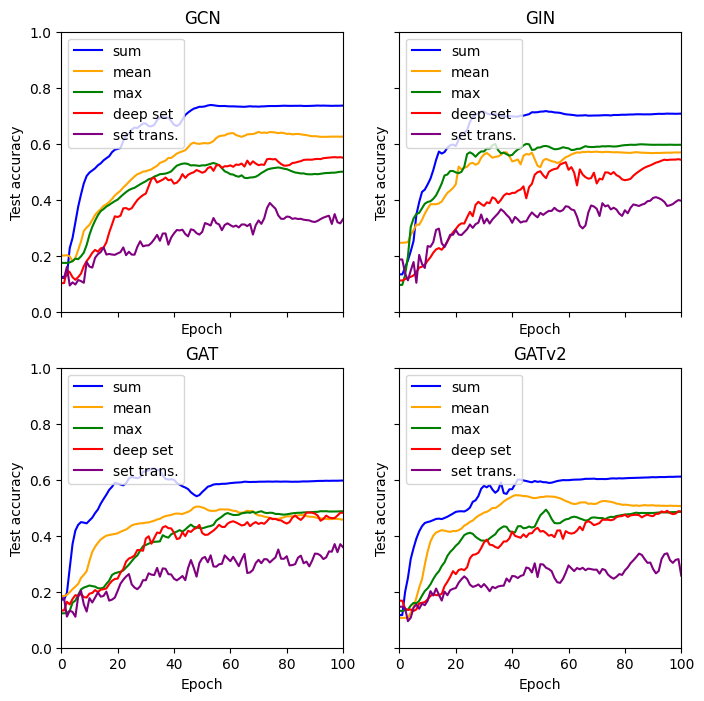

In [ ]:
colours = dict(zip(aggrs, ['blue','orange','green','red','purple']))
def plot_four_models(hists):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(8,8)) # Nice 2x2 layout
    
    for ax, conv in zip([ax1,ax2,ax3,ax4],convs):
        for aggr in aggrs:
            ax.plot(hists[conv][aggr], label=aggr, color=colours[aggr])

        ax.legend()
        ax.set_title(conv)
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Test accuracy')
        ax.set_ybound(lower=0,upper=1.0)
        ax.set_xbound(lower=0,upper=NUM_EPOCHS)
    
    plt.show()

plot_four_models(hists)